In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor,
                              RandomForestClassifier, ExtraTreesClassifier)
from IPython import display
from utils import play_from_label, grouped_bar_chart, number_countplot
import keys
import evaluation

In [3]:
DATA_DIR = './data/working'

labels = pd.read_pickle("{}/labels.pkl".format(DATA_DIR))

with np.load("{}/splits.npz".format(DATA_DIR)) as splits:
    train_idx = splits['train_idx']
    test_idx = splits['test_idx']

X = np.load("{}/X_cqt.npz".format(DATA_DIR))['X']
X_train = X[train_idx, :]
X_test = X[test_idx, :]

Y = np.load("{}/Y.npz".format(DATA_DIR))['Y']
Y_train = Y[train_idx, :]
Y_test = Y[test_idx, :]

# with np.load("{}/data_aug.npz".format(DATA_DIR)) as data:
#     X_aug = data['X']
#     Y_aug = data['Y']
# X_train = np.vstack(X_train, X_aug)
# Y_train = np.vstack(Y_train, Y_aug)

In [4]:
X_train.shape, Y_train.shape

((12683, 144, 151), (12683, 24))

In [5]:
X_test.shape, Y_test.shape

((4227, 144, 151), (4227, 24))

In [6]:
iloc = 2

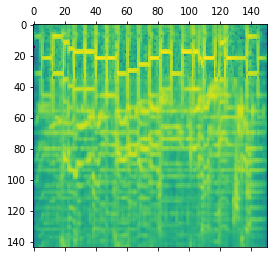

In [7]:
plt.matshow(X_train[iloc])

In [8]:
idx = train_idx[iloc]
labels.loc[idx]

chunk_idx                                                    22
chunk_nr                                                    148
filepath      data/raw/lmd_matched_mp3/J/Q/V/TRJQVEQ128F149D...
genre                                                         J
key                                                           7
key_shift                                                     0
key_str                                                 E major
raw                                                           1
time_shift                                                    1
majmin                                                    major
dataset                                                 million
Name: 8019, dtype: object

In [9]:
play_from_label(labels.loc[idx])

In [10]:
X_train_mean = np.mean(X_train, axis=2)
X_test_mean = np.mean(X_test, axis=2)

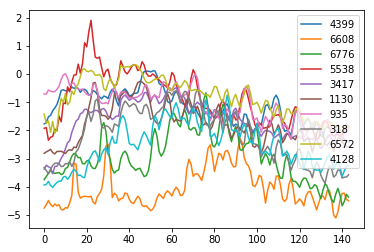

In [11]:
idx_list = np.random.choice(X_train_mean.shape[0], 10)
for ii in idx_list:
    plt.plot(X_train_mean[ii], label=ii)
plt.legend()
plt.show()

Centre the data about the mean value over the frequencies

In [12]:
mask = np.sum(~ np.isfinite(X_train_mean), axis=1) == 0  ## temp solution so we dont have inf rows
X_train_mean = X_train_mean[mask]
Y_train = Y_train[mask]

In [13]:
mask = np.sum(~ np.isfinite(X_test_mean), axis=1) == 0  ## temp solution so we dont have inf rows
X_test_mean = X_test_mean[mask]
Y_test = Y_test[mask]

In [14]:
X_train_mean -= np.mean(X_train_mean, axis=1, keepdims=True)
X_test_mean -= np.mean(X_test_mean, axis=1, keepdims=True)

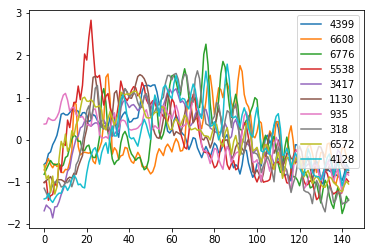

In [15]:
for ii in idx_list:
#     mean = np.mean(X_train_mean[ii])
#     plt.plot(X_train_mean[ii]-mean, label=ii)
    plt.plot(X_train_mean[ii], label=ii)
plt.legend()
plt.show()

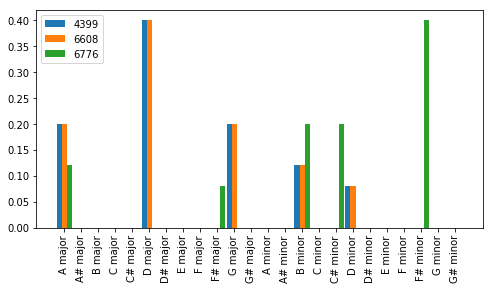

In [16]:
plt.figure(figsize=(8,4))
nr_bars = 3
bar_labels = [ss.replace('\t', ' ') for ss in keys.STRING_MAP]
grouped_bar_chart(Y[idx_list[:nr_bars]], legend_labels=idx_list[:nr_bars],
                  bar_labels=bar_labels, border_size=0.1, legend=True)
plt.xticks(rotation=90)
plt.show()

# Modelling

## Spectrogram vectors (mean over time)

In [17]:
def train_and_score(mdl, X=X_train_mean, Y=Y_train, X_test=X_test_mean, Y_test=Y_test):
    mdl.fit(X, Y)
    pred_prob_train = mdl.predict(X)
    y_train = np.argmax(Y_train, axis=1)
    pred_train = np.argmax(pred_prob_train, axis=1)
    pred_prob = mdl.predict(X_test)
    
    plt.figure()
    grouped_bar_chart(np.mean((Y_test - pred_prob)**2, axis=0, keepdims=True))
    pred = np.argmax(pred_prob, axis=1)
    y_test = np.argmax(Y_test, axis=1)
    
    
    plt.figure()
    evaluation.plot_confusion_matrix(y_train, pred_train, title='Train', norm=True, annot=False)
    
    plt.figure()
    evaluation.plot_confusion_matrix(y_test, pred, title='Test', norm=True, annot=False)
    
    scores_train = evaluation.get_scores(y_train, pred_train)
    plt.figure()
    plt.title('Train scores. Avg = {:.3f}'.format(np.mean(scores_train)))
    sns.countplot(scores_train)
    number_countplot()
    
    scores = evaluation.get_scores(y_test, pred)
    plt.figure()
    plt.title('Test scores. Avg = {:.3f}'.format(np.mean(scores)))
    sns.countplot(scores)
    number_countplot()
    return np.mean(scores)

### Linear Regression

In [18]:
linreg = LinearRegression()

0.6450674237047551

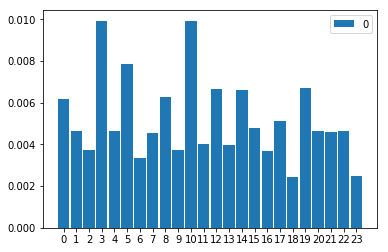

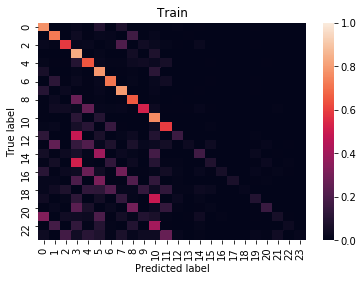

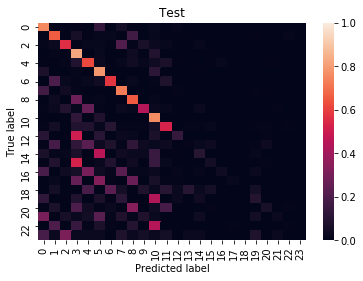

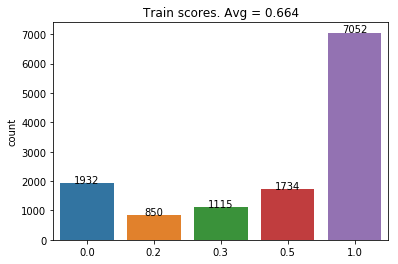

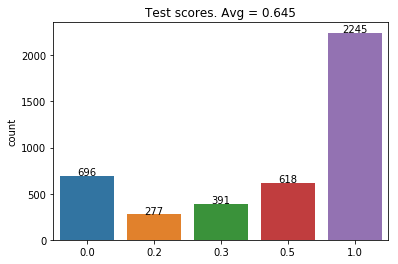

In [19]:
train_and_score(linreg)

### Decision Tree

In [20]:
# dt = DecisionTreeRegressor(max_depth=7, random_state=1337)
# dt = DecisionTreeRegressor(min_samples_leaf=0.001, random_state=1337)
dt = DecisionTreeRegressor(min_samples_split=0.02, random_state=1337)

0.4836527087769103

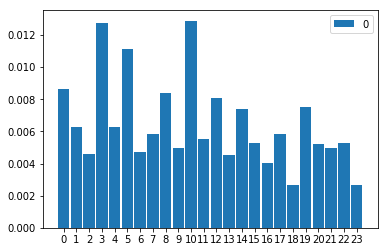

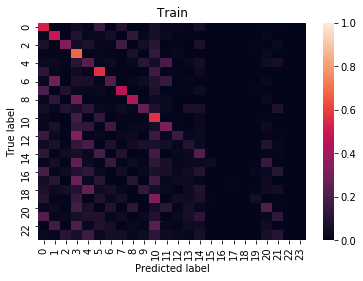

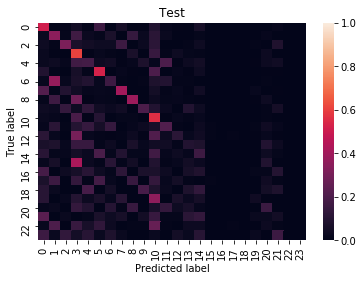

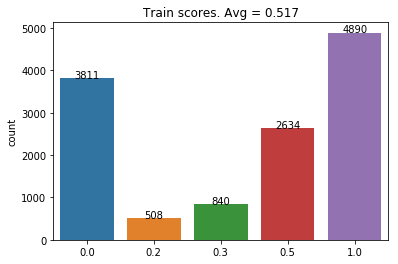

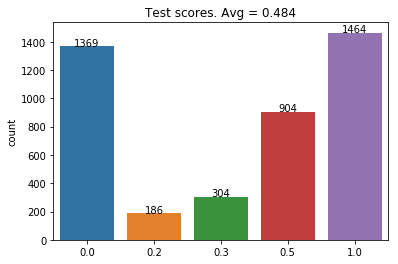

In [21]:
train_and_score(dt)

### Random Forest

In [22]:
# rf = RandomForestRegressor(n_estimators=100, max_depth=7)  #.42
# rf = RandomForestRegressor(n_estimators=100, min_samples_split=0.01, max_features=.05) #0.48
# rf = RandomForestRegressor(n_estimators=100, min_samples_split=0.01, max_features=.1) #.5
# rf = RandomForestRegressor(n_estimators=100, min_samples_split=0.01, max_features=.25) #.51
# rf = RandomForestRegressor(n_estimators=100, min_samples_split=0.01, max_features=.5) #..49
rf = RandomForestRegressor(n_estimators=500, min_samples_split=0.01, max_features=.25)

0.6074047788029335

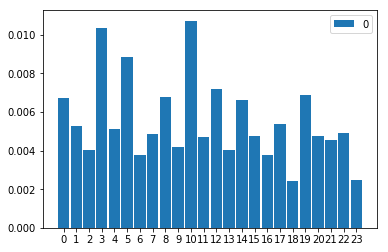

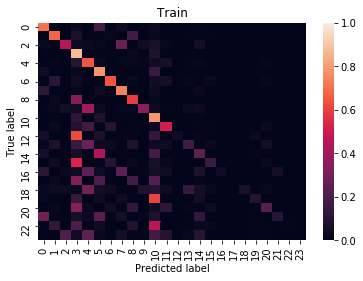

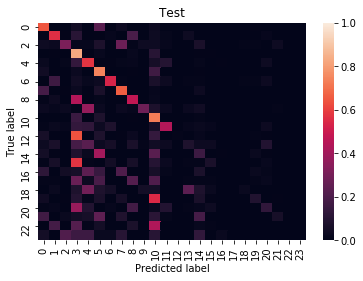

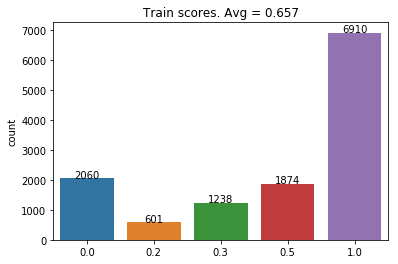

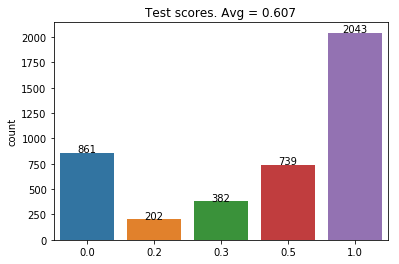

In [23]:
train_and_score(rf)

### Extra Trees

In [24]:
etr = ExtraTreesRegressor(n_estimators=100)

0.6667139815471965

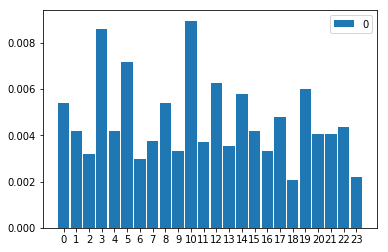

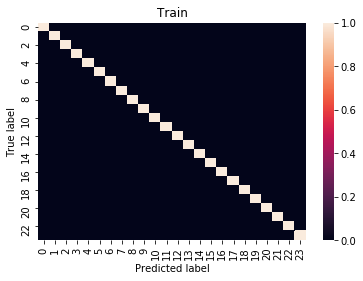

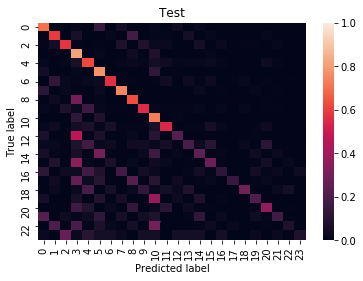

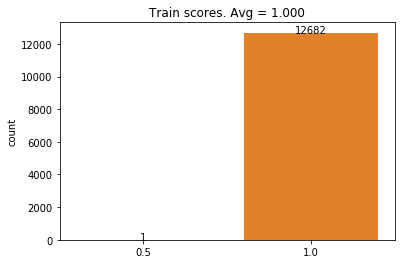

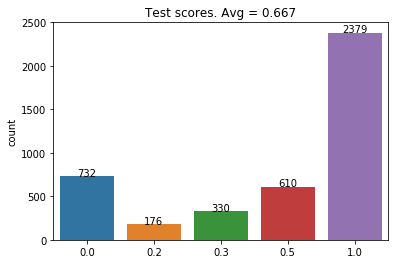

In [25]:
train_and_score(etr)

## Spectrogram vectors (as a classification)

In [26]:
y_train = np.argmax(Y_train, axis=1)
y_test = np.argmax(Y_test, axis=1)

In [27]:
def train_and_score_clf(mdl, X=X_train_mean, y=y_train, X_test=X_test_mean, y_test=y_test):
    mdl.fit(X, y)
    pred_train = mdl.predict(X)
    plt.figure()
    evaluation.plot_confusion_matrix(y, pred_train, title='Train', norm=True, annot=False)
    pred = mdl.predict(X_test)
    plt.figure()
    evaluation.plot_confusion_matrix(y_test, pred, title='Test', norm=True, annot=False)
    scores_train = evaluation.get_scores(y, pred_train)
    plt.figure()
    plt.title('Train scores. Avg = {:.3f}'.format(np.mean(scores_train)))
    sns.countplot(scores_train)
    number_countplot()
    scores = evaluation.get_scores(y_test, pred)
    plt.figure()
    plt.title('Test scores. Avg = {:.3f}'.format(np.mean(scores)))
    sns.countplot(scores)
    number_countplot()
    return np.mean(scores)

### Logistic

In [28]:
logistic = LogisticRegression()

0.691554293825408

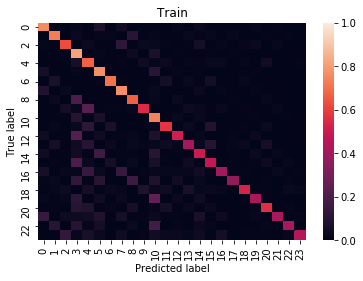

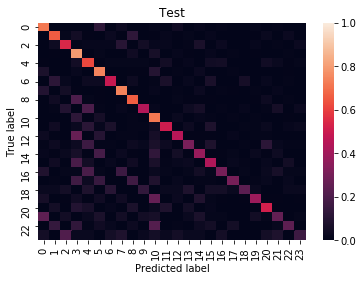

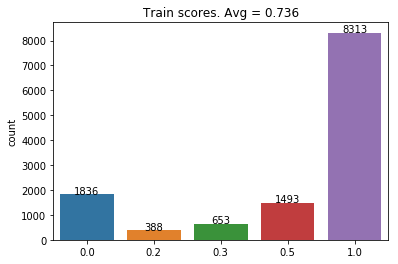

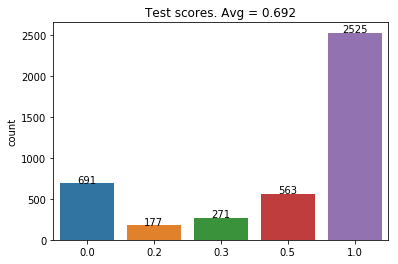

In [29]:
train_and_score_clf(logistic)

### Decision Tree

In [30]:
dtc = DecisionTreeClassifier(min_samples_split=0.03, random_state=1337)

0.4656257392950083

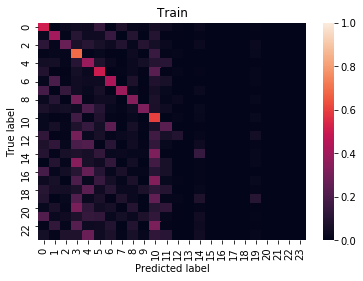

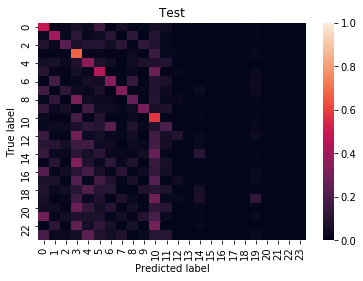

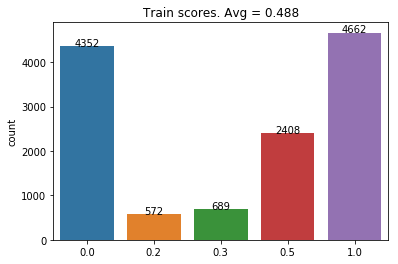

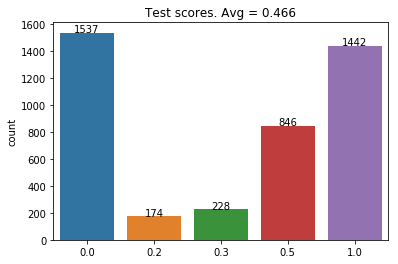

In [31]:
train_and_score_clf(dtc)

### RF

In [32]:
# rfc = RandomForestClassifier(n_estimators=100, max_features=.5)  #.46
# rfc = RandomForestClassifier(n_estimators=100, max_features=.25)  #.44
# rfc = RandomForestClassifier(n_estimators=100, max_features=.05)  #.44
# rfc = RandomForestClassifier(n_estimators=100, max_features=.1)  #.46
rfc = RandomForestClassifier(n_estimators=200, max_features=.1)  #.46
# rfc = RandomForestClassifier(n_estimators=100, max_features=.25, max_depth=10)  #.43
# rfc = RandomForestClassifier(n_estimators=100, max_features=.1, max_depth=10)  #.43
# rfc = RandomForestClassifier(n_estimators=100, max_features=.1, min_samples_split=0.01)  #.43
# rfc = RandomForestClassifier(n_estimators=100, max_features=.1, min_samples_split=0.03) #.39

0.6490655311095339

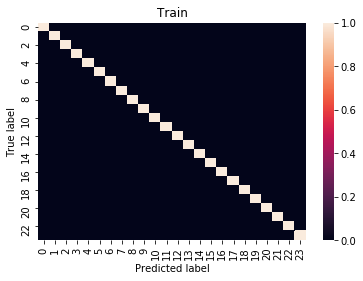

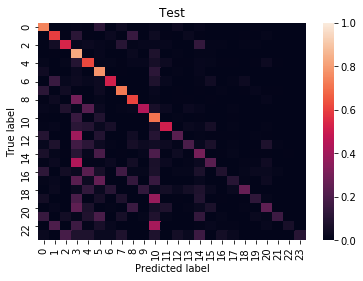

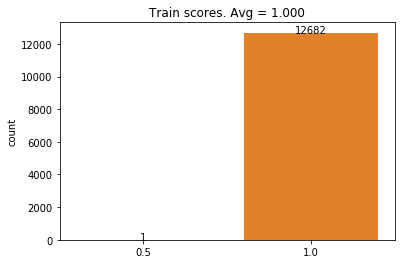

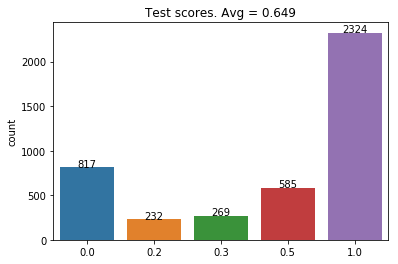

In [33]:
train_and_score_clf(rfc)

### Extra trees

In [34]:
etc = ExtraTreesClassifier(n_estimators=500)

0.6448308493021055

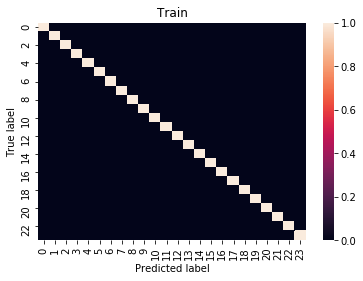

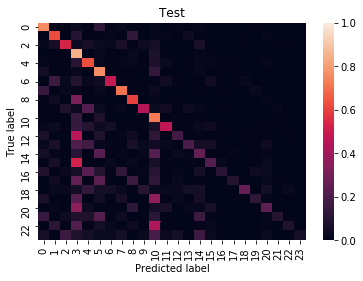

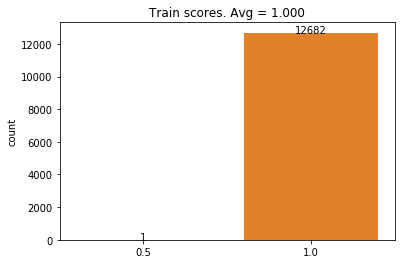

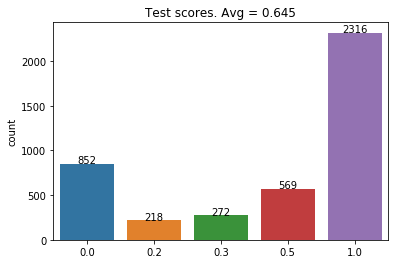

In [35]:
train_and_score_clf(etc)